In [1]:
import csv
import binascii
from datetime import datetime
from pprint import pprint

import baos_knx_parser as knx

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

from sklearn import datasets
from sklearn import svm
from sklearn import feature_selection
from sklearn.neighbors import LocalOutlierFactor, kneighbors_graph

In [2]:
iris = datasets.load_iris()

In [3]:
# Generate some training data
np.random.seed(41)
X_train = np.r_[
    # 0.56 * np.random.randn(98, 2) + (2, 2),
    # 0.40 * np.random.randn(82, 2) - (2, 2),
    # 0.25 * np.random.randn(30, 2) + (2, -2),
    0.80 * np.random.randn(50, 2) + (2, 2),
    0.40 * np.random.randn(50, 2) - (2, 2),
    0.25 * np.random.randn(50, 2) + (2, -2.5),
]

# Generate some test data
np.random.seed(42)
# Some random noise
X_test = np.r_[
    0.80 * np.random.randn(50, 2) + (2, 2),
    0.45 * np.random.randn(40, 2) - (2, 2),
    0.25 * np.random.randn(50, 2) + (2, -2.5),
]
X_outliers = np.random.uniform(low=-4, high=4, size=(50, 2))

X = np.r_[X_test, X_outliers]

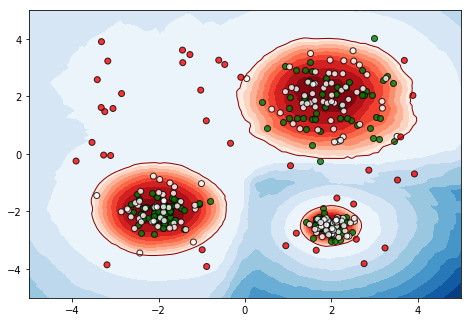

In [4]:
# fit the model
clf = LocalOutlierFactor(n_neighbors=30, algorithm='auto', metric='minkowski', p=2, contamination=0.20, n_jobs=-1)
clf.fit(X_train)
#y_pred = clf._decision_function(X)
#y_pred_test = clf._decision_function(X_test)
#y_pred_outlier = clf._decision_function(X_outliers)
y_pred = clf.fit_predict(X)

# plot the level sets of the decision function
xx, yy = np.meshgrid(np.linspace(-5, 5, 100),
                     np.linspace(-5, 5, 100))
Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#plt.title("Local Outlier Factor (LOF)")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), clf.threshold_, 10), cmap=plt.cm.Blues_r)
plt.contour(xx, yy, Z, levels=[clf.threshold_], linewidths=1, linestyles='solid', colors='darkred')
plt.contourf(xx, yy, Z, levels=np.linspace(clf.threshold_, Z.max(), 10), cmap=plt.cm.Reds)

plt.scatter(X_train[:,0], X_train[:,1], c='g', edgecolor='k', alpha=0.8)
plt.scatter(X[:,0], X[:,1], c=['w' if p > 0 else 'r' for p in y_pred], edgecolor='k', alpha=0.8)

plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
#plt.legend([a, b],
#           ["normal observations",
#            "abnormal observations"],
#           loc="upper left")
plt.gca().set_position([0, 0, 1, 1])
plt.savefig("200-background-lof.pdf", format="pdf")

In [5]:
l = np.r_[np.linspace(Z.min(), Z.max(), 10), [clf.threshold_]]
l.sort()
l

array([-7.28308331, -6.57714479, -5.87120627, -5.16526775, -4.45932923,
       -3.75339071, -3.04745219, -2.34151367, -1.63557515, -1.44113291,
       -0.92963663])

In [6]:
t = pd.DataFrame([X_outliers[1], X[20], (-2, -2), (-4, -4), (4, -4)])
print(clf.threshold_)
print(clf._decision_function(t) * -1)
print(clf._predict(t))

-1.4411329113706604
[1.61756237 0.99821788 0.95499103 2.52249184 4.55053949]
[-1  1  1 -1 -1]


In [7]:
#df = pd.DataFrame(np.random.randn(200, 5))
df = pd.DataFrame(np.random.random_sample((200, 5)))
df.head()

,0,1,2,3,4
0,0.056303,0.118818,0.117526,0.649210,0.746045
1,0.583369,0.962173,0.374871,0.285712,0.868599
2,0.223596,0.963223,0.012154,0.969879,0.043160
3,0.891143,0.527701,0.992965,0.073797,0.553854
4,0.969303,0.523098,0.629399,0.695749,0.454541


In [8]:
df.mean()

0    0.512219
1    0.494630
2    0.512252
3    0.492246
4    0.491297
dtype: float64

In [9]:
bins = df[0].value_counts(bins=5)
bins.values

array([44, 42, 41, 39, 34])

In [10]:
pk = df[0].value_counts(bins=5).values
qk = np.array((82, 53, 33, 19, 8))
print(len(pk), len(qk))
stats.entropy(pk, qk)

5 5


0.21957836580390883

In [11]:
stats.entropy(
    df.mean(),
    np.array([0.003, 0.012, 0.059, 0.061142, 0.0155])
)

0.5079817261987879

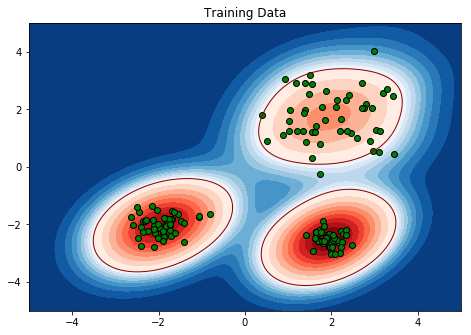

In [12]:
from scipy import stats

# plot decision planes
xx, yy = np.meshgrid(np.linspace(-5, 5, 200), 
                     np.linspace(-5, 5, 200))

pos = np.vstack([xx.ravel(), yy.ravel()])
kernel = stats.gaussian_kde(np.vstack([X_train[:,0], X_train[:,1]]), 'silverman')

Z = np.reshape(kernel(pos).T, xx.shape)

#threshold = 1.2e-02
threshold = Z.min() + (Z.max() - Z.min()) * 0.2

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 10), cmap=plt.cm.Blues_r)
plt.contour(xx, yy, Z, levels=[threshold], linewidths=1, colors='darkred')
plt.contourf(xx, yy, Z, levels=np.linspace(threshold, Z.max(), 10), cmap=plt.cm.Reds)

plt.scatter(X_train[:,0], X_train[:,1], c='g', edgecolor='k')

plt.title('Training Data')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.gca().set_position([0, 0, 1, 1])
plt.show()

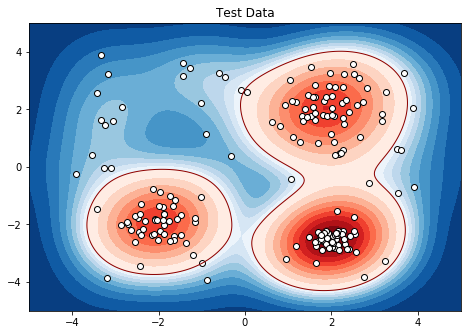

In [13]:
# plot decision planes
xx, yy = np.meshgrid(np.linspace(-5, 5, 200), 
                     np.linspace(-5, 5, 200))

pos = np.vstack([xx.ravel(), yy.ravel()])
kernel = stats.gaussian_kde(np.vstack([X[:,0], X[:,1]]), 'silverman')

Z = np.reshape(kernel(pos).T, xx.shape)

#threshold = 1.2e-02
threshold = Z.min() + (Z.max() - Z.min()) * 0.2

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 10), cmap=plt.cm.Blues_r)
plt.contour(xx, yy, Z, levels=[threshold], linewidths=1, colors='darkred')
plt.contourf(xx, yy, Z, levels=np.linspace(threshold, Z.max(), 10), cmap=plt.cm.Reds)

plt.scatter(X[:,0], X[:,1], c='w', edgecolor='k')

plt.title('Test Data')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.gca().set_position([0, 0, 1, 1])
plt.show()

In [14]:
Z.min(), Z.max(), np.linspace(Z.min(), Z.max(), 10)

(2.7121366986903757e-05,
 0.04996304430413117,
 array([2.71213670e-05, 5.57555725e-03, 1.11239931e-02, 1.66724290e-02,
        2.22208649e-02, 2.77693008e-02, 3.33177367e-02, 3.88661725e-02,
        4.44146084e-02, 4.99630443e-02]))

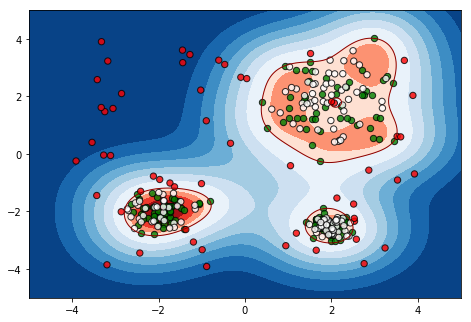

In [15]:
clf = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma='auto')
clf.fit(X_train)

# plot decision planes
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), 
                     np.linspace(-5, 5, 500))

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

y_pred = clf.predict(X)

#plt.title('One Class Support Vector Machine (SVM)')
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 8), cmap=plt.cm.Blues_r, alpha=1)
plt.contour(xx, yy, Z, levels=[0], linewidths=1, colors='darkred', alpha=1)
plt.contourf(xx, yy, Z, levels=np.linspace(0, Z.max(), 5), cmap=plt.cm.Reds) # colors='palevioletred')

plt.scatter(X_train[:,0], X_train[:,1], c='g', edgecolor='k', alpha=0.8, s=40)
plt.scatter(X[:,0], X[:,1], c=['w' if p > 0 else 'r' for p in y_pred], edgecolor='k', alpha=0.8, s=40)

plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.gca().set_position([0, 0, 1, 1])
plt.savefig("200-background-oneclass.pdf", format="pdf")